In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from scipy.stats import boxcox

In [18]:
data = pd.read_csv('data/importaciones_gasolina.csv')

# Seleccionando columnas de interes
columns = ['Fecha', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel alto azufre']
data = data[columns]

# Renombrando columnas
new_column_names = ['fecha', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre', 'gas_licuado_petroleo', 'gasolina_regular', 'gasolina_superior', 'diesel_alto_azufre']
data.columns = new_column_names

# Eliminando filas con valores nulos
data = data.dropna()

# Convirtiendo fecha a formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

data


/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_10229/1056520668.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,fecha,diesel_bajo_azufre,diesel_ultra_bajo_azufre,gas_licuado_petroleo,gasolina_regular,gasolina_superior,diesel_alto_azufre
0,2001-01-01,0.00,0.00,"194,065.74","177,776.50","373,963.96","566,101.99"
1,2001-02-01,0.00,0.00,"170,703.38","123,115.99","243,091.07","489,525.80"
2,2001-03-01,0.00,0.00,"161,837.37","161,726.42","312,084.38","575,559.68"
3,2001-04-01,0.00,0.00,"163,048.64","127,338.74","285,054.89","437,745.42"
4,2001-05-01,0.00,0.00,"171,518.86","168,730.19","300,913.67","552,609.13"
...,...,...,...,...,...,...,...
264,2023-01-01,"1,442,099.08","45,074.97","497,780.69","909,391.13","578,792.14",0.00
265,2023-02-01,"1,267,967.39",0.00,"652,984.71","725,101.20","685,183.06",0.00
266,2023-03-01,"1,317,519.91","4,985.21","711,978.35","803,262.67","633,849.05",0.00
267,2023-04-01,"1,417,182.73","21,503.98","647,666.30","922,032.39","572,201.36",0.00


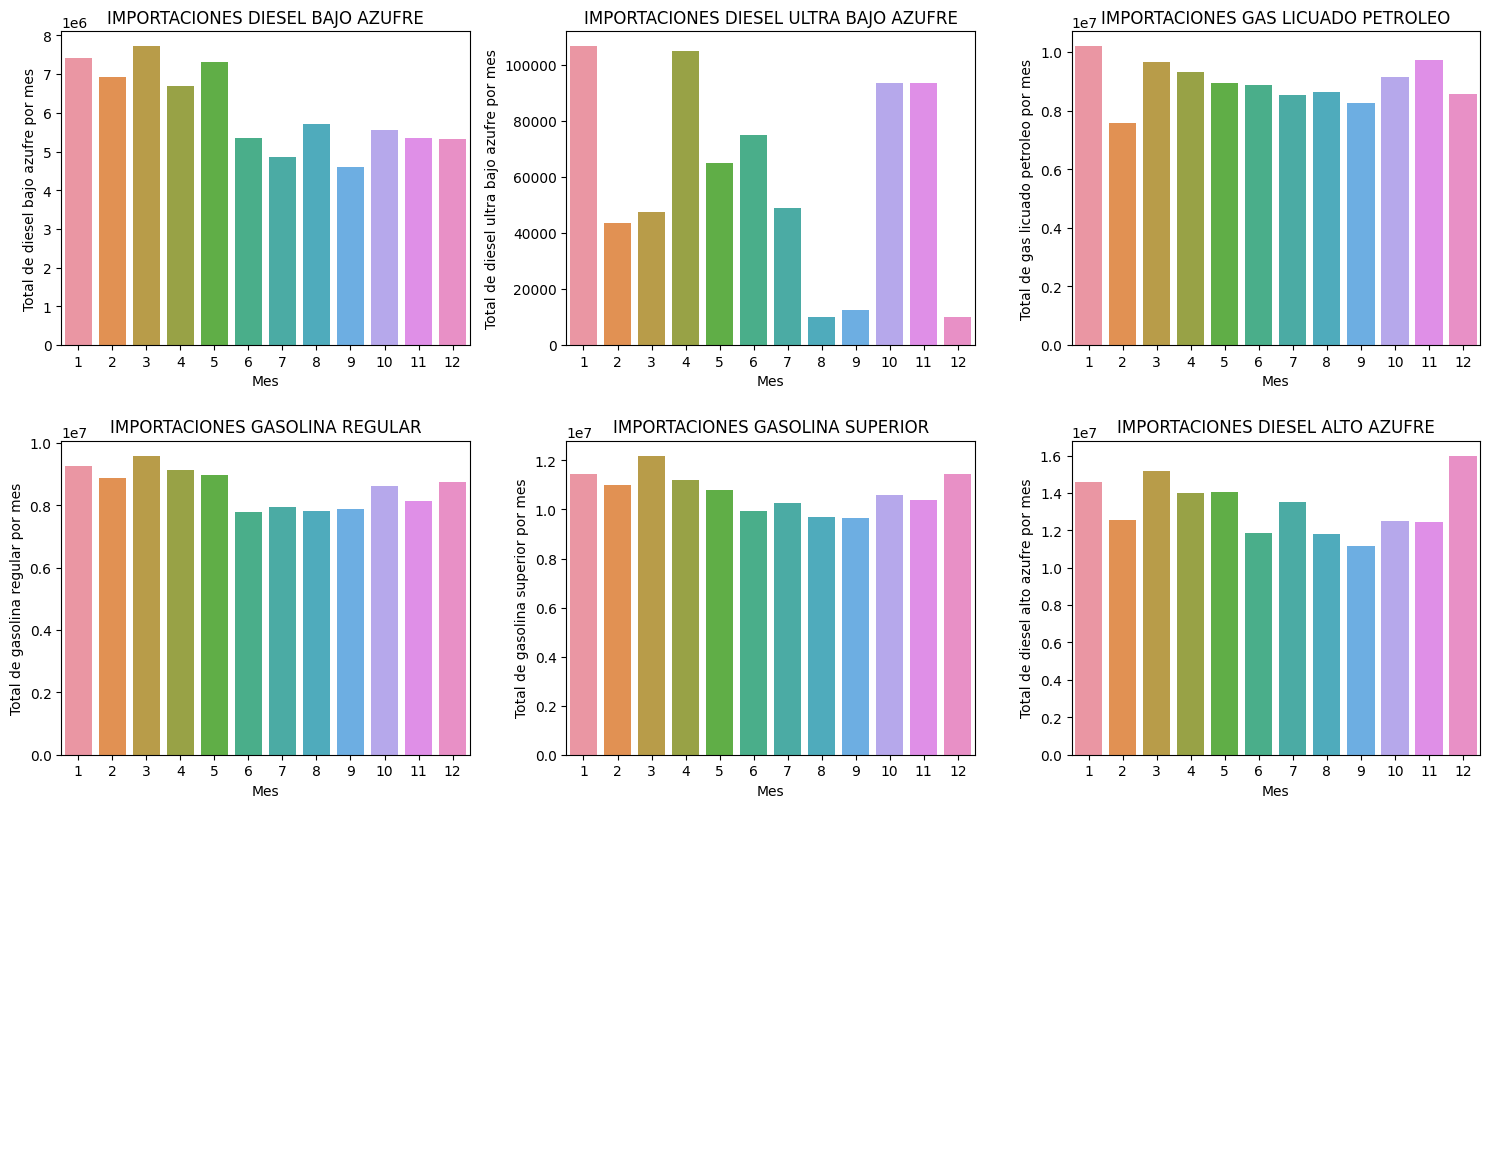

In [19]:
data['mes'] = data['fecha'].dt.month
columns = [col for col in data.columns if col not in ['fecha', 'mes']]

frequency_rows = len(columns) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 4* frequency_rows))
axs = axs.flatten()

for ax, column in zip(axs, columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    monthly_values = data.groupby('mes')[column].sum()
    
    sns.barplot(x=monthly_values.index, y=monthly_values.values, ax=ax)
    ax.set_title(f"IMPORTACIONES {' '.join(column.split('_')).upper()}")
    ax.set_xlabel('Mes')
    ax.set_ylabel(f"Total de {' '.join(column.split('_'))} por mes")

for ax in axs[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [36]:
data['anio'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month

frequency_cols = 2
columns = [col for col in data.columns if col not in ['fecha', 'mes', 'anio']]
fig = make_subplots(rows=frequency_rows, cols=frequency_cols, subplot_titles=[f"Comportamiento de {' '.join(column.split('_'))} (2001-2023)" for column in columns], vertical_spacing=0.12)

for i, column in enumerate(columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    year_values = data.groupby('anio')[column].sum()
    trace = go.Scatter(x=year_values.index, y=year_values.values, name=f"Total {' '.join(column.split('_'))}", mode='lines+markers')    
    fig.add_trace(trace, row=(i // frequency_cols) + 1, col=(i % frequency_cols) + 1)

height_p = 350 
height_p = height_p * frequency_rows

fig.update_layout(showlegend=False, height=height_p)
fig.update_xaxes(title_text="Año")
fig.update_yaxes(title_text=f"Total")

fig.show()


## Serie - Importación mensual de gasolina diesel bajo azufre

- Inicio: 2018-01-01
- Fin: 2023-05-01
- Frecuencia: Mensual

In [37]:
data_dba = data[data['fecha'] >= '2018-01-01']
data_daa = data[data['fecha'] <= '2017-12-01']

# rename columns
data_dba = data_dba.rename(columns={'diesel_bajo_azufre': 'diesel'})
data_daa = data_daa.rename(columns={'diesel_alto_azufre': 'diesel'})

# concat dataframes
data_diesel = pd.concat([data_dba, data_daa], axis=0)
data_diesel = data_diesel.sort_values(by='fecha')

# drop columns
data_diesel = data_diesel.drop(columns=['diesel_alto_azufre', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre'])
data_dba = data_diesel

In [22]:
data_dba.freq = 'M'

data_dba = data_dba.copy() 
data_dba['media_movil'] = data_dba['diesel'].rolling(window=12).mean()
rolling_mean = data_dba['diesel'].rolling(window=12).mean()

fig = px.line(data_dba, x='fecha', y='diesel', labels={'diesel': 'Cantidad de diesel Bajo Azufre'}, title='Diesel Bajo Azufre por mes', markers=True)
fig.add_scatter(x=data_dba['fecha'], y=rolling_mean, mode='lines', name='Media móvil - 12 meses')

fig.update_xaxes(tickformat="%Y", title_text='Año')
fig.update_traces(line=dict(width=2.5))
fig.show()


A primera vista no se observa estacionaridad en media ni en varianza.

### Descomposición de la serie

In [23]:
d_serie_dba = seasonal_decompose(data_dba.set_index('fecha')['diesel'].astype(float))
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Tendencia', 'Estacionalidad', 'Aleatoriedad'))

fig.add_trace(go.Scatter(x=d_serie_dba.trend.index, y=d_serie_dba.trend, mode='lines', name='Tendencia'), row=1, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.seasonal.index, y=d_serie_dba.seasonal, mode='lines', name='Estacionalidad'), row=2, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.resid.index, y=d_serie_dba.resid, mode='lines', name='Aleatoriedad'), row=3, col=1)

fig.update_layout(title='Descomposición de la serie de tiempo - Diesel Bajo Azufre')
fig.show()

Hay una tendencia evidente y una estacionalidad notable. En cuanto al componente de aleatoriedad, no se identifica ningún patrón.

### Transformación de la serie
La serie requiere una transformación de tipo box-cox dado que no es estacionaria en varianza.

In [44]:
data_dba['diesel_boxcox'] = boxcox(data_dba['diesel'])[0]
fig = px.line(data_dba, x='fecha', y='diesel_boxcox', title='Diesel - Transformación box cox', markers=True)

fig.show()


Se ve un cambio mínimo al momento de aplicar box-cox.

### Estacionaridad en media

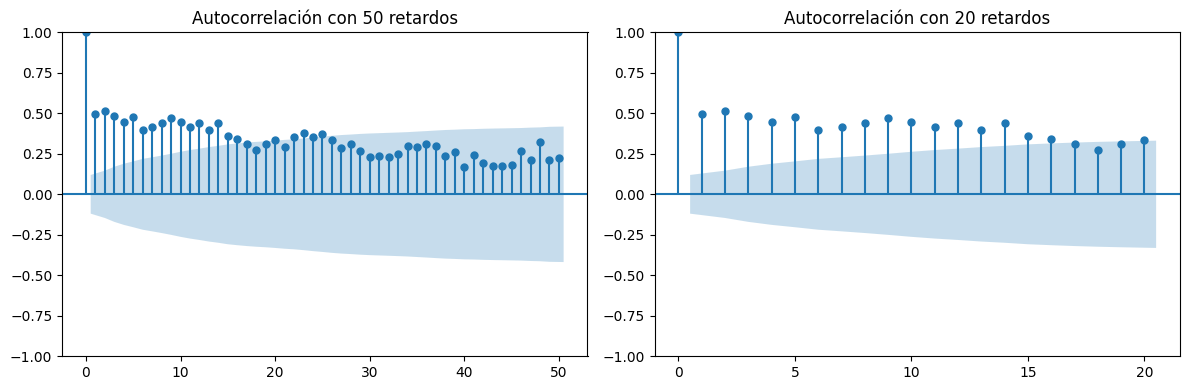

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the autocorrelation with 50 lags on the first subplot
plot_acf(data_dba['diesel_boxcox'], lags=50, ax=ax[0])
ax[0].set_title("Autocorrelación con 50 retardos")

plot_acf(data_dba['diesel_boxcox'], lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación con 20 retardos")

# Display the figure
plt.tight_layout()
plt.show()

In [46]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(data_dba['diesel_boxcox'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.344631
p-value                        0.608515
# de retardos usados          13.000000
# de observaciones usadas    255.000000
Critical Value (1%)           -3.456257
Critical Value (5%)           -2.872942
Critical Value (10%)          -2.572846
dtype: float64


En base al gráfico de autocorrelación y el test de Dickey Fuller se confirma que la serie no es estacionaria en media. Porque no se ve que algunos de los puntos salgan del área sombreada y se puede rechazar la hipótesis nula del test de Dickey Fuller ya que xel valor de p es menor a 0.05, lo cual también indica que no hay niguna raíz unitaria, por tanto, si es estacionaria en media.

### Parámetros p, d y q

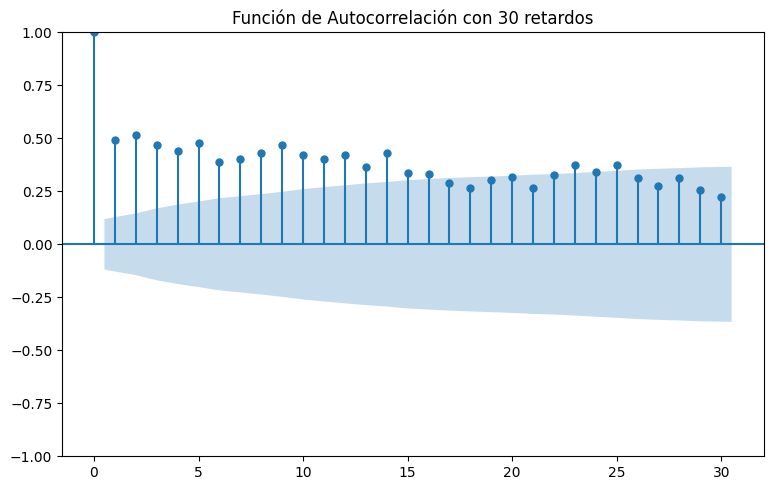

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

plt.subplot(121) 
plot_acf(data_dba['diesel_log'].dropna(), lags=30, ax=plt.gca(), title='Función de Autocorrelación con 30 retardos')

plt.tight_layout()
plt.show()


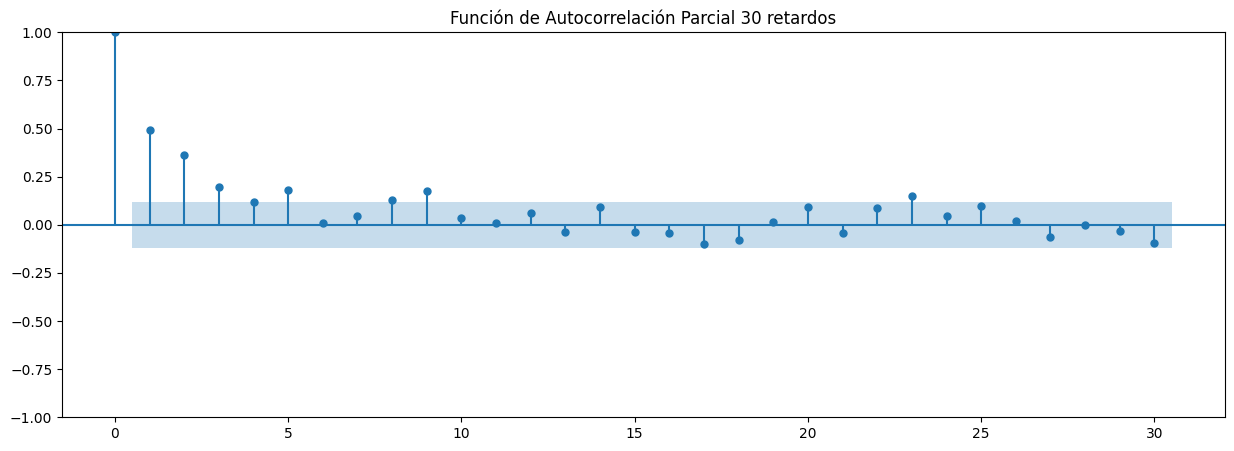

In [22]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

plot_pacf(data_dba['diesel_log'], lags=30, title='Función de Autocorrelación Parcial 30 retardos', alpha=0.05)
plt.show()
